# Stanford CME 241 (Winter 2021) - Midterm Exam

In [1]:
import numpy as np
from scipy.stats import poisson
from pprint import pprint
from dataclasses import dataclass
from typing import Tuple, Mapping, Dict, Sequence, Iterable, Set, List
from rl.distribution import Categorical, Constant
import matplotlib.pyplot as plt

from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.dynamic_programming import value_iteration_result

### Q1 Value Iteration Optimization.

In [15]:
SPACE = 'SPACE'
BLOCK = 'BLOCK'
GOAL = 'GOAL'

maze_grid: Mapping[Tuple[int, int], str] = {(0, 0): SPACE, (0, 1): BLOCK, (0, 2): SPACE, (0, 3): SPACE, (0, 4): SPACE, 
                         (0, 5): SPACE, (0, 6): SPACE, (0, 7): SPACE, (1, 0): SPACE, (1, 1): BLOCK,
                         (1, 2): BLOCK, (1, 3): SPACE, (1, 4): BLOCK, (1, 5): BLOCK, (1, 6): BLOCK, 
                         (1, 7): BLOCK, (2, 0): SPACE, (2, 1): BLOCK, (2, 2): SPACE, (2, 3): SPACE, 
                         (2, 4): SPACE, (2, 5): SPACE, (2, 6): BLOCK, (2, 7): SPACE, (3, 0): SPACE, 
                         (3, 1): SPACE, (3, 2): SPACE, (3, 3): BLOCK, (3, 4): BLOCK, (3, 5): SPACE, 
                         (3, 6): BLOCK, (3, 7): SPACE, (4, 0): SPACE, (4, 1): BLOCK, (4, 2): SPACE, 
                         (4, 3): BLOCK, (4, 4): SPACE, (4, 5): SPACE, (4, 6): SPACE, (4, 7): SPACE, 
                         (5, 0): BLOCK, (5, 1): BLOCK, (5, 2): SPACE, (5, 3): BLOCK, (5, 4): SPACE, 
                         (5, 5): BLOCK, (5, 6): SPACE, (5, 7): BLOCK, (6, 0): SPACE, (6, 1): BLOCK, 
                         (6, 2): BLOCK, (6, 3): BLOCK, (6, 4): SPACE, (6, 5): BLOCK, (6, 6): SPACE, 
                         (6, 7): SPACE, (7, 0): SPACE, (7, 1): SPACE, (7, 2): SPACE, (7, 3): SPACE, 
                         (7, 4): SPACE, (7, 5): BLOCK, (7, 6): BLOCK, (7, 7): GOAL}

In [16]:
def track(f):
    def wrapped(mdp, vf, s):
        res = f(mdp, vf, s)
        updated = vf.copy()
        mdp.iterates.append(updated)
    return wrapped


@dataclass(frozen=True)
class GridState:
    x: int
    y: int
    
    def neighbors(self) -> Iterable[GridState]:
        return [GridState(self.x-1, self.y), GridState(self.x+1, self.y),
                GridState(self.x, self.y-1), GridState(self.x, self.y+1)]

    def __lt__(self, other: GridState):
        return (self.x, self.y) < (other.x, other.y) # use to compare

In [17]:
class GridMazeMDP:
    def __init__(self, maze_dict):
        self.iterates = [] # dont need to change
        self.tolerance = 1e-8
    
        self.states: Set[GridState] = set([GridState(x[0], x[1]) for x, y in maze_dict.items()
                                           if y == 'SPACE' or y == 'GOAL'])
        # return the x-coordinate of the terminal state
        self.goal: GridState = [GridState(x[0], x[1]) for x,y in maze_dict.items() if y == 'GOAL'][0]
        # discount factor - to be changed
        self.gamma: float = 1
    
    def reward_func(self, next_state) -> float:
        return -1
    
    def plot_convergence(self, label):
        sorted_vfs = np.array([[y[1] for y in sorted(x.items())] for x in self.iterates])
        true_vf = sorted_vfs[-1, :]
        convergences = np.linalg.norm(sorted_vfs - true_vf, axis=1)
        plt.plot(convergences, label=label)
    
    def get_vd(self):
        return self.iterates[-1]
    
    @track
    def update_value_function_for_state(self, value_function: Mapping[GridState, float], s: GridState) -> None:
        if s != self.goal:
            neighbor_value_functions = []
            for neighbor in s.neighbors():
                # not a block
                if neighbor in self.states:
                    # neighbor: vf = -1(immediate reward) + gamma * vf'
                    neighbor_value_functions.append(self.reward_func(neighbor) + self.gamma * value_function[neighbor])
            value_function[s] = max(neighbor_value_functions)
        else:
            value_function[s] = 0 #vf for the goal state
        
    def in_place_value_iteration(self) -> Mapping[GridState, float]:
        value_function = {s: 0 for s in self.states}
        # initialize with 1 to make sure we enter the loop; then use it as a variable to compare with tolerance
        max_change = 1
        # while not converge
        while max_change > self.tolerance:
            max_change = 0
            for state in self.states:
                old_val = value_function[state]
                self.update_value_function_for_state(value_function, state)
                # abs(old_vf - update_vf) > tolerance (not converge); continue the while loop
                max_change = max(max_change, abs(old_val-value_function[state]) > self.tolerance)
        return value_function

##################################### this is a influence tree value iteration method

    def influence_tree_VI(self) -> Mapping[GridState, float]: 
        value_function = {s: 0 for s in self.states}
        influence_tree = self.get_influence_tree() #return a dictionary {state: [neighbor_state1, neighbor_state_2 ...]}
        to_update = [s for s in self.states]
        in_list = {s: True for s in self.states}
        while len(to_update) > 0:
            # we pop states orderly
            next_state = to_update.pop(0)
            in_list[next_state] = False
            old_val = value_function[next_state]
            self.update_value_function_for_state(value_function, next_state)
            if abs(old_val - value_function[next_state]) > self.tolerance:
                for s in influence_tree[next_state]:
                    # if we have met the neighbor state before, we append it to to_update again (Question)
                    if not in_list[s]:
                        to_update.append(s)
        return value_function
                          
    def get_influence_tree(self) -> Mapping[GridState, Iterable[GridState]]:
        influence_tree = {}
        count = 0
        for state in self.states:
            # for each 'space' state, we get a list of its neighbor states
            influence_tree[state] = []
            for neighbor in state.neighbors():
                if neighbor != self.goal and neighbor in self.states:
                    influence_tree[state].append(neighbor)
        return influence_tree

####################################

class SparseGridMazeMDP(GridMazeMDP):
    
    def __init__(self, maze_dict):
        super().__init__(maze_dict)
        self.gamma: float = 0.9
    
    def reward_func(self, next_state) -> float:
        if next_state == self.goal:
            return 1
        return 0
            

class SparseGridMazeMDP(GridMazeMDP):
    """In this case, only the goal state has reward 1, while other space states reward 0"""
    def __init__(self, maze_dict):
        super().__init__(maze_dict)
        self.gamma: float = 0.9
    
    def reward_func(self, next_state) -> float:
        if next_state == self.goal:
            return 1
        return 0

in place value iteration with dense rewards took 429 steps to converge
influence tree value iteration took 427 steps to converge


Text(0.5, 1.0, 'dense rewards')

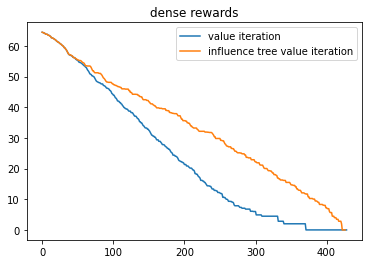

In [19]:
gm1 = GridMazeMDP(maze_grid)
gm2 = GridMazeMDP(maze_grid)
vf1 = gm1.in_place_value_iteration()
print(f"in place value iteration with dense rewards took {len(gm1.iterates)} steps to converge")
gm1.plot_convergence("value iteration")
vf2 = gm2.influence_tree_VI()
print(f"influence tree value iteration took {len(gm2.iterates)} steps to converge")
gm2.plot_convergence("influence tree value iteration")
plt.legend()
plt.title("dense rewards")

in place value iteration with sparse rewards took 390 steps to converge
influence tree value iteration took 113 steps to converge


Text(0.5, 1.0, 'sparse rewards')

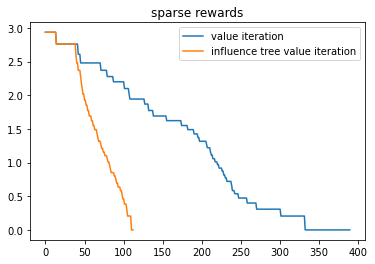

In [20]:
gm1 = SparseGridMazeMDP(maze_grid)
gm2 = SparseGridMazeMDP(maze_grid)
vf1 = gm1.in_place_value_iteration()
print(f"in place value iteration with sparse rewards took {len(gm1.iterates)} steps to converge")
gm1.plot_convergence("value iteration")
vf2 = gm2.influence_tree_VI()
print(f"influence tree value iteration took {len(gm2.iterates)} steps to converge")
gm2.plot_convergence("influence tree value iteration")
plt.legend()
plt.title("sparse rewards")

### Q2 MRP Value Function Approximation.

 We start with the matrix bellman equations
 $$ V=R+\gamma PV $$
 Using linear function approximation, we get
 $$ \tilde{V} = \Phi \cdot w $$
 where $ \Phi$ is a $ n \times m $ matrix of features for all states. If we need $\tilde{V} = V$:
 $$ \Phi \cdot w = R + \gamma P \cdot \Phi \cdot w $$ 
 $$ (I - \gamma P) \cdot \Phi \cdot w = R   $$
 $$ \Phi \cdot w = (I - \gamma P)^{-1} \cdot R $$
Thus, a minimally sufficient condition is hold is that the vector $ (I - \gamma P)^{-1} \cdot R $ must lie in the span of m vectors comprising the columns of the matrix $\Phi$

### Q3 Career Optimization.

In [6]:
IntPair = Tuple[int, int]
CareerDecisionsMap = Mapping[int, Mapping[
    IntPair,
    Categorical[Tuple[int, float]]
]]

In [7]:
class CareerOptimization(FiniteMarkovDecisionProcess[int, IntPair]):
    
    def __init__(
        self,
        hours: int,
        wage_cap: int,
        alpha: float,
        beta: float
    ):
        self.hours = hours
        self.wage_cap = wage_cap
        self.alpha = alpha
        self.beta = beta
        super().__init__(self.get_transitions())
    
    def get_transitions(self) -> CareerDecisionsMap:
        d: Dict[int, Mapping[IntPair, Categorical[Tuple[int, float]]]] = {}
        for w in range(1, self.wage_cap+1):
            d1: Dict[IntPair, Categorical[Tuple[int, float]]] = {}
            for s in range(self.hours+1):
                for t in range(self.hours+1-s):
                    pd = poisson(self.alpha*t)
                    prob: float = self.beta*s/self.hours
                    r: float = w*(self.hours-s-t)
                    same_prob: float = (1-prob) * pd.pmf(0)
                    sr_probs: Dict[Tuple[int, float], float] = {}
                    # special case1
                    if w == self.wage_cap:
                        sr_probs[(w,r)] = 1.
                    # special case2
                    elif w == self.wage_cap-1:
                        sr_probs[(w,r)] = same_prob
                        sr_probs[(w+1,r)] = 1-same_prob
                    # cases (a bit confused about this part)
                    else:
                        sr_probs[(w,r)] = same_prob
                        sr_probs[(w+1,r)] = prob*pd.pmf(0)+pd.pmf(1) 
                        for w1 in range(w+2, self.wage_cap):
                            sr_probs[(w1, r)] = pd.pmf(w1-w)
                        sr_probs[(self.wage_cap,r)] = 1 - pd.cdf(self.wage_cap-w-1)
                    d1[(s,t)] = Categorical(sr_probs)
            d[w] = d1
        return d   

{1: (0, 10),
 2: (0, 10),
 3: (0, 10),
 4: (0, 10),
 5: (0, 10),
 6: (0, 10),
 7: (0, 10),
 8: (0, 10),
 9: (0, 10),
 10: (0, 10),
 11: (0, 10),
 12: (0, 10),
 13: (0, 10),
 14: (10, 0),
 15: (10, 0),
 16: (0, 0),
 17: (0, 0),
 18: (0, 0),
 19: (0, 0),
 20: (0, 0),
 21: (0, 0),
 22: (0, 0),
 23: (0, 0),
 24: (0, 0),
 25: (0, 0),
 26: (0, 0),
 27: (0, 0),
 28: (0, 0),
 29: (0, 0),
 30: (0, 0)}


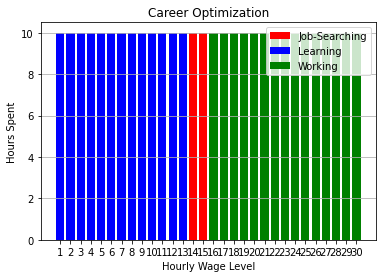

In [17]:
hours: int = 10
# hours: int = 13
wage_cap: int = 30
alpha: float = 0.08
# alpha: float = 0.10
beta: float = 0.82
# beta: float = 0.9
gamma: float = 0.95

co: CareerOptimization = CareerOptimization(
    hours=hours,
    wage_cap=wage_cap,
    alpha=alpha,
    beta=beta
)
        
_, opt_policy = value_iteration_result(co, gamma=gamma) #this is from rl.dynamic_programming
wages: Iterable[int] = range(1, co.wage_cap + 1)
opt_actions: Mapping[int, Tuple[int, int]] =\
    {w: opt_policy.act(w).value for w in wages} #{wage1: (s1, l1), wage2: (s2, l2), ...}
searching: Sequence[int] = [s for _, (s, _) in opt_actions.items()]
learning: Sequence[int] = [l for _, (_, l) in opt_actions.items()]
working: Sequence[int] = [co.hours - s - l for _, (s, l) in
                          opt_actions.items()]
pprint(opt_actions)
plt.xticks(wages)
p1 = plt.bar(wages, searching, color='red')
p2 = plt.bar(wages, learning, color='blue')
p3 = plt.bar(wages, working, color='green')
plt.legend((p1[0], p2[0], p3[0]), ('Job-Searching', 'Learning', 'Working'))
plt.grid(axis='y')
plt.xlabel("Hourly Wage Level")
plt.ylabel("Hours Spent")
plt.title("Career Optimization")
plt.show()

Action on any given day $ (l,s) $; Action space $ \{(l,s) | 0 \leq l+s \leq H\} $; Reward on any given day $R(w, (l,s)) = w \cdot (H-l-s) $
<br> $$P [w'|(w, (s,l))] = \begin{gather*}
\begin{cases}
  0  & w'<w \\    
  (1-p(s))\cdot f_{\alpha l} (0)  & w=w'<W\\  
  p(s)\cdot f_{\alpha l} (0) + f_{\alpha l} (1)  & w+1=w'<W\\
  f_{\alpha l} (w'-w) & w+1<w'<W\\
  1  & w=w'=W\\
  1-(1-p(s))\cdot f_{\alpha l} (0)  & w+1=w'=W\\
  1-F_{\alpha l} (w'-w-1)  & w+1<w'=W
\end{cases}
\end{gather*}$$
where $f_{\lambda}$ is the Poisson PMF, while $F_{\lambda}$ is the Poisson CDF.